# Script per la stima di $g$

Questo file e il file `modules\functions.py` contengono il codice sorgente per l'analisi dati dell'esperimento di laboratorio, riguardante la misura del valore dell'accelerazione gravitazionale.

### Importare le librerie

In [33]:
from os import listdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from modules import functions

plt.style.use("modules/mystyle.mplstyle")

np.set_printoptions(precision=5)

### Importare i dati

Dati del cronometro

In [34]:
data_crono_mattia = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Mattia"
)
data_crono_matilde = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Matilde"
)
data_crono_filippo = pd.read_excel(
    "data/Misure accel grav giorno2.xlsx", sheet_name="Filippo"
)

data_cronos = [data_crono_mattia, data_crono_matilde, data_crono_filippo]

Dati del fototraguardo

In [35]:
# * Nomi dei datasets per il fotogate datasets_names_mattia
dataset_names_mattia = [
    f"misura fototraguardo lunghezza {'1(min)' if i == 0 else f'{i+1}_tia'}"
    for i in range(5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_mattia = [206.10, 172.58, 128.24, 99.22, 67.90]

dataset_names_matilde = [
    f"misura fototraguardo lunghezza {f'{i+1}_mat'}" for i in range(1, 5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_matilde = [172.58, 127.06, 99.08, 67.86]

dataset_names_filippo = [
    f"misura fototraguardo lunghezza {f'{i+1}_fil'}" for i in range(2, 5)
]
# da "Misure accel grav giorno2.xlsx"
lunghezze_associate_filippo = [127.46, 99.06, 67.56]

dataset_different_angles = [
    "misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi",
]


## Analisi per il cronometro

~~~~~ Set Cronometro Mattia ~~~~~
Lunghezze:  [381.40108 414.90612 459.22969 488.24055 519.55184 557.4426 ]
Periodi (MS):  [1.23936 1.29293 1.36277 1.40159 1.45042 1.49653]
Incertezza sui periodi (MS):  [0.00894 0.00675 0.00643 0.00639 0.00661 0.0065 ]
Periodi (MM):  [1.23953 1.29305 1.36145 1.40222 1.44741 1.49778]
Incertezza sui periodi (MM):  [0.00031 0.00029 0.00023 0.00023 0.00027 0.00025]
Parametri della regressione (MS):
	A=0.004022 ±0.000136
	B=0.004743 ±0.064487
(MS) g = 9815.6±331.4 mm/s^2
p-value (compatibilità con g attesa): 0.9782179632880048
p-value (compatibilità con intercetta): 0.9449039464928242
chi2red: 0.1357254252853758
Parametri della regressione (MM):
	A=0.004018 ±0.000005
	B=0.005436 ±0.002443
(MM) g = 9824.7±12.6 mm/s^2
p-value (compatibilità con g attesa): 0.21201906335071818
p-value (compatibilità con intercetta): 0.09561888782622097
chi2red: 10.30609808517159
~~~~~ Set Cronometro Matilde ~~~~~
Lunghezze:  [381.40108 414.90612 460.4093  488.38051 519.59183 55

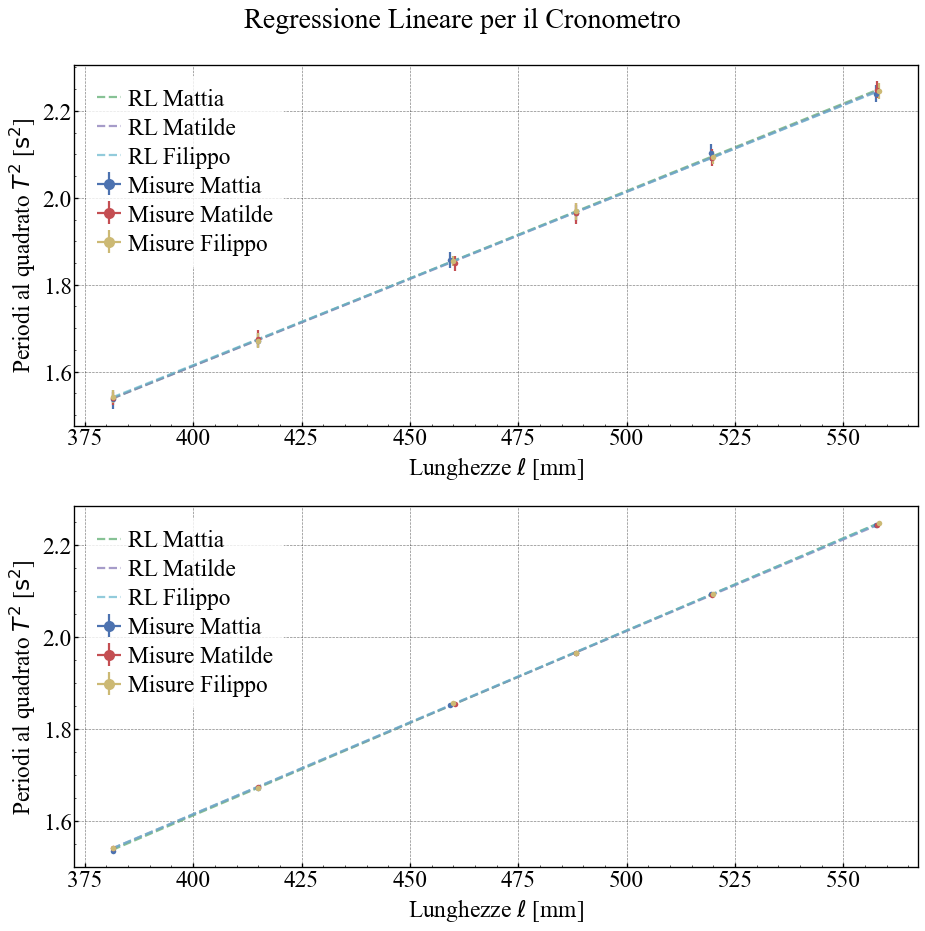

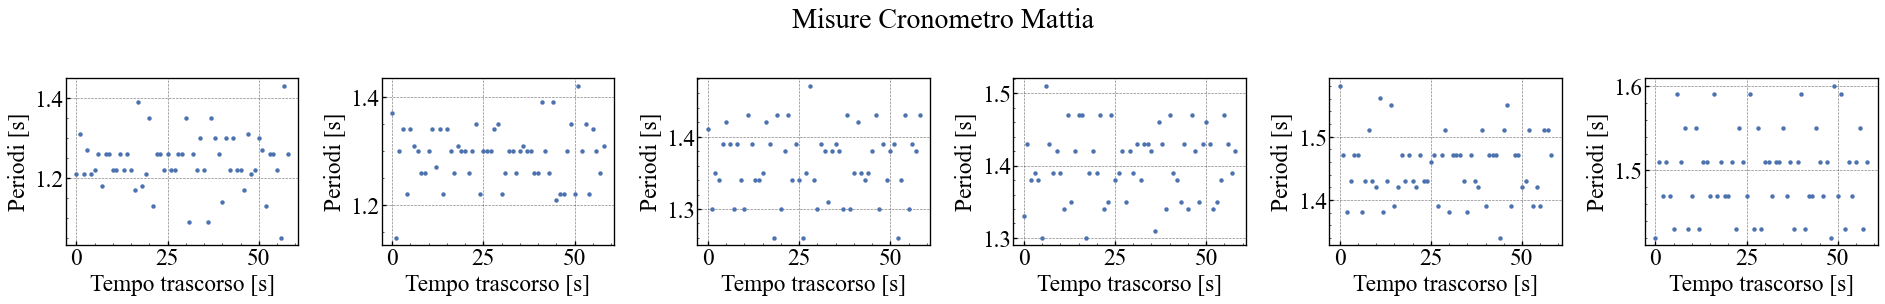

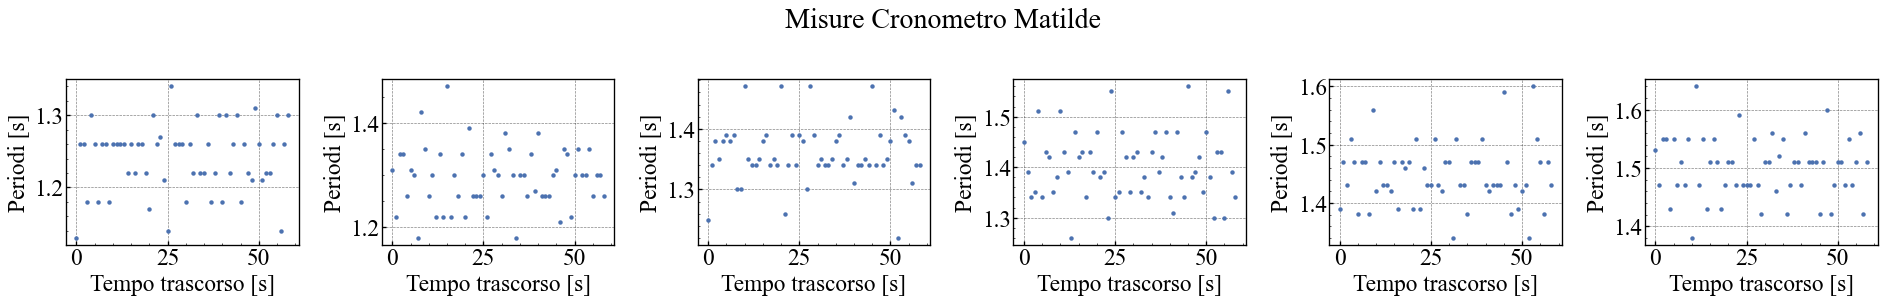

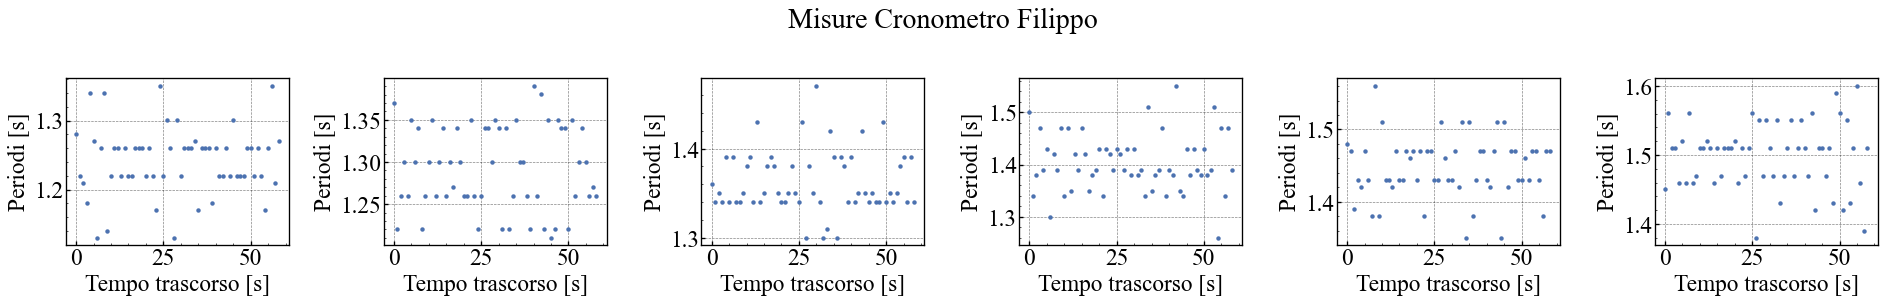

In [36]:
import scipy.stats


names = ["Mattia", "Matilde", "Filippo"]

Fig, AX = plt.subplots(2, 1, figsize=(12, 12))
plt.suptitle("Regressione Lineare per il Cronometro")
AX[0].set_xlabel(r"Lunghezze $\ell$ [mm]")
AX[1].set_xlabel(r"Lunghezze $\ell$ [mm]")
AX[0].set_ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
AX[1].set_ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")

for i, dataset in enumerate(data_cronos):
    X = dataset.columns.values
    X = functions.calc_length(X)
    periods = dataset.T.to_numpy() * 1.00017
    mean_periods_MS, std_periods_MS = functions.calc_average(periods)
    mean_periods_MM, std_periods_MM = functions.calc_moving_average(periods)

    # * show sets
    fig, ax = plt.subplots(1, 6, figsize=(24, 4))
    plt.suptitle(f"Misure Cronometro {names[i]}")
    for j, set in enumerate(periods):
        ax[j].scatter(np.arange(len(set)), set)
        ax[j].set_xlabel(r"Tempo trascorso [s]")
        ax[j].set_ylabel(r"Periodi [s]")

    Y_MS = np.square(mean_periods_MS)
    Yerr_MS = 2 * np.multiply(mean_periods_MS, std_periods_MS)
    Y_MM = np.square(mean_periods_MM)
    Yerr_MM = 2 * np.multiply(mean_periods_MM, std_periods_MM)

    AX[0].errorbar(
        X,
        Y_MS,
        Yerr_MS,
        xerr=0.02,
        ls="",
        marker=".",
        label=f"Misure {names[i]}",
        markersize=10,
        elinewidth=2
    )
    AX[1].errorbar(
        X,
        Y_MM,
        Yerr_MM,
        xerr=0.02,
        ls="",
        marker=".",
        label=f"Misure {names[i]}",
        markersize=10,
        elinewidth=2
    )


    print(f"~~~~~ Set Cronometro {names[i]} ~~~~~")
    print("Lunghezze: ", X)
    print("Periodi (MS): ", mean_periods_MS)
    print("Incertezza sui periodi (MS): ", std_periods_MS)
    print("Periodi (MM): ", mean_periods_MM)
    print("Incertezza sui periodi (MM): ", std_periods_MM)

    # reg lin per media semplice
    Yuncert_MS = np.sqrt(np.square(Yerr_MS) + (0.02*0.004)**2)
    params, uncert = functions.calc_reg_lin(X, Y_MS, Yuncert_MS)
    print(f"Parametri della regressione (MS):\n\tA={params[0]:.6f} ±{uncert[0]:.6f}\n\tB={params[1]:.6f} ±{uncert[1]:.6f}")
    g_value = (4 * np.pi**2) / params[0]
    g_uncert = g_value * uncert[0] / params[0]
    print(f"(MS) g = {abs(g_value):.1f}±{g_uncert:.1f} mm/s^2")
    print(f"p-value (compatibilità con g attesa): {functions.calc_p_value(g_value, g_uncert, 9806, 4)}")
    print(f"p-value (compatibilità con intercetta): {functions.calc_p_value(params[1], (uncert[1]**2 + (params[1]*0.1)**2)**0.5, 0, 4)}")

    X_reg = np.linspace(min(X), max(X), 100)
    Y_reg = params[0] * X_reg + params[1]
    AX[0].plot(X_reg, Y_reg, alpha=0.7, ls="--", label=f"RL {names[i]}", linewidth=2)

    observed = Y_MS
    expected = X * params[0] + params[1]
    chi = functions.calc_chi2(observed, expected, Yuncert_MS, 4)
    print(f"chi2red: {chi[2]}")

    # reg lin per media mobile
    Yuncert_MM = np.sqrt(np.square(Yerr_MM) + (0.02*0.004)**2)
    params, uncert = functions.calc_reg_lin(X, Y_MM, Yuncert_MM)
    print(f"Parametri della regressione (MM):\n\tA={params[0]:.6f} ±{uncert[0]:.6f}\n\tB={params[1]:.6f} ±{uncert[1]:.6f}")
    g_value = (4 * np.pi**2) / params[0]
    g_uncert = g_value * uncert[0] / params[0]
    print(f"(MM) g = {abs(g_value):.1f}±{g_uncert:.1f} mm/s^2")
    print(f"p-value (compatibilità con g attesa): {functions.calc_p_value(g_value, g_uncert, 9806, 4)}")
    print(f"p-value (compatibilità con intercetta): {functions.calc_p_value(params[1], (uncert[1]**2 + (params[1]*0.1)**2)**0.5, 0, 4)}")

    X_reg = np.linspace(min(X), max(X), 100)
    Y_reg = params[0] * X_reg + params[1]
    AX[1].plot(X_reg, Y_reg, alpha=0.7, ls="--", label=f"RL {names[i]}", linewidth=2)

    observed = Y_MM
    expected = X * params[0] + params[1]
    chi = functions.calc_chi2(observed, expected, Yuncert_MM, 4)
    print(f"chi2red: {chi[2]}")
    #print(f"p-value chi2: {scipy.stats.chi2.sf(chi[1], df=4)}")


AX[0].legend()
AX[1].legend()
Fig.savefig("images/Regressione Lineare Cronometro.svg")

## Analisi per il fototraguardo

Controllo dei dati ottenuti, come output ci sono i periodi e i periodi al quadrato per i vari set di misure, e (in ordine) le immagini che rappresentato i set

Misura Fototraguardo Lunghezza 1(Min)   
	Periodi medi: 1.23870 ± 0.00005
	Periodi quadri medi: 1.53439 ± 0.00013
Misura Fototraguardo Lunghezza 2_Mat    
	Periodi medi: 1.29270 ± 0.00003
	Periodi quadri medi: 1.67107 ± 0.00009
Misura Fototraguardo Lunghezza 2_Tia    
	Periodi medi: 1.29315 ± 0.00003
	Periodi quadri medi: 1.67222 ± 0.00007
Misura Fototraguardo Lunghezza 3_Fil    
	Periodi medi: 1.36314 ± 0.00003
	Periodi quadri medi: 1.85816 ± 0.00007
Misura Fototraguardo Lunghezza 3_Mat    
	Periodi medi: 1.36223 ± 0.00002
	Periodi quadri medi: 1.85566 ± 0.00006
Misura Fototraguardo Lunghezza 3_Tia    
	Periodi medi: 1.36203 ± 0.00002
	Periodi quadri medi: 1.85513 ± 0.00006
Misura Fototraguardo Lunghezza 4_Fil    
	Periodi medi: 1.40177 ± 0.00003
	Periodi quadri medi: 1.96495 ± 0.00007
Misura Fototraguardo Lunghezza 4_Mat    
	Periodi medi: 1.40234 ± 0.00003
	Periodi quadri medi: 1.96655 ± 0.00009
Misura Fototraguardo Lunghezza 4_Tia    
	Periodi medi: 1.40327 ± 0.00002
	Periodi quadr

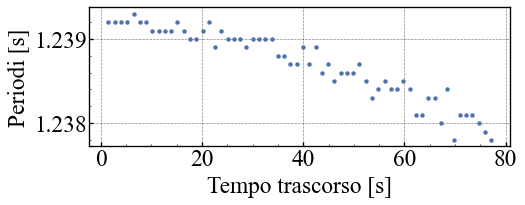

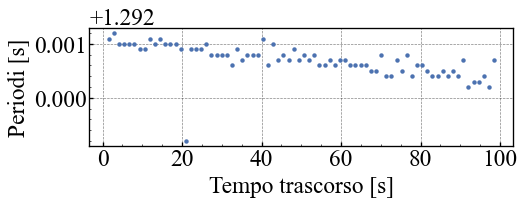

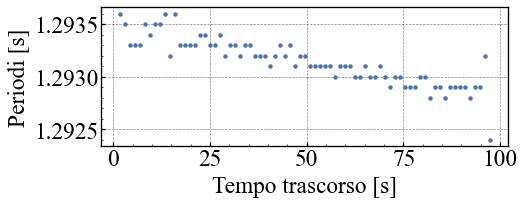

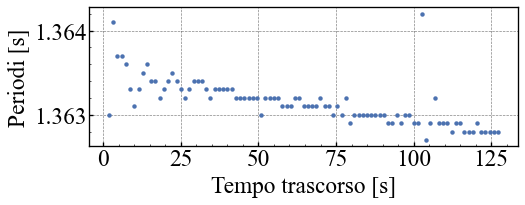

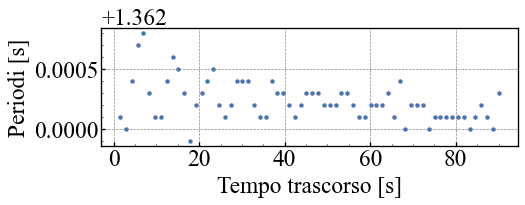

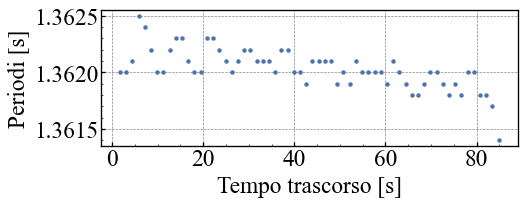

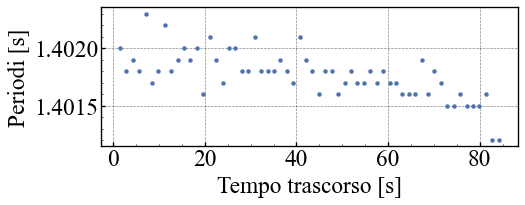

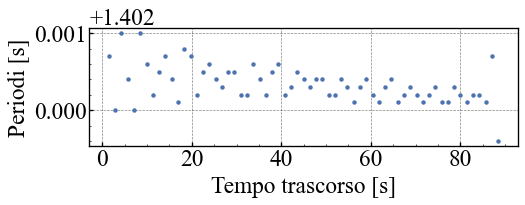

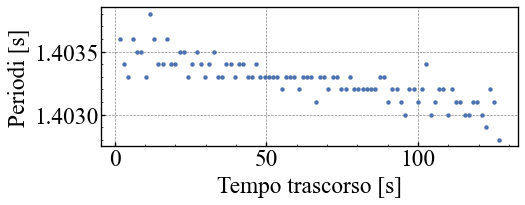

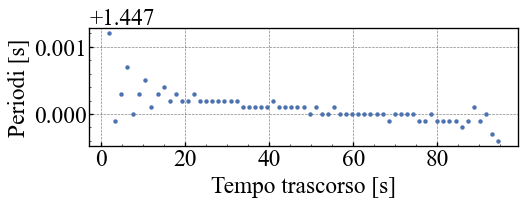

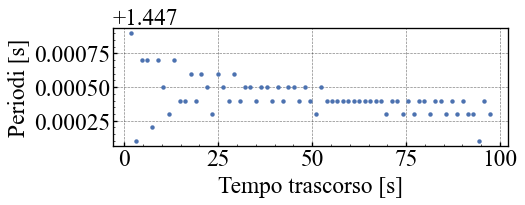

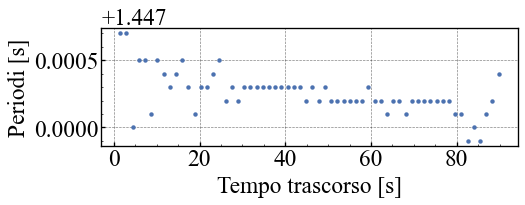

In [37]:
datasets_names = [
    f[:-4]
    for f in listdir("data")
    if f
    not in [
        ".DS_Store",
        "Misure accel grav giorno2.xlsx",
        "~$Misure accel grav giorno2.xlsx",
        "misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv",
        "Pendolo.xlsx",
    ]
]

lunghezze = np.array(
        [
            206.10,
            172.58,
            172.58,
            127.46,
            127.06,
            128.24,
            99.06,
            99.08,
            99.22,
            67.56,
            67.86,
            67.90,
        ]
    )

datasets_names.sort()

datasets = {}
for dataset_name in datasets_names:
    with open(f"data/{dataset_name}.csv", "r") as file:
        datasets[dataset_name] = pd.read_csv(file, sep=";", decimal=",").dropna()

periods = []
std_periods = []

for dataset_name, dataset in datasets.items():
    X = dataset.iloc[:, 0].to_numpy()
    Y = dataset.iloc[:, 1].to_numpy()

    mean_period, std_period = functions.calc_average(Y)
    # * non ha senso utilizzare la media mobile per il fototraguardo perché è troppo preciso

    print(
        f"{dataset_name.title():<40}",
        f"Periodi medi: {mean_period:.5f} ± {std_period:.5f}",
        f"Periodi quadri medi: {mean_period**2:.5f} ± {2*std_period*mean_period:.5f}",
        sep="\n\t"
    )
    periods.append(mean_period)
    std_periods.append(std_period)

    plt.subplots(figsize=(7, 3))
    plt.scatter(X, Y)

    plt.xlabel(r"Tempo trascorso [s]")
    plt.ylabel(r"Periodi [s]")

periods = np.array(periods) * 1.00017
std_periods = np.array(std_periods)

Analisi effettiva per il fototraguardo.

Come output ci sono le lunghezze, i periodi (con incertezza), i valori di parametri della regressione lineare, il valore di $g$, le p-value del test di student per la compatibilità di $g$ col valore atteso e di $B$ con lo zero, e infine il $\chi^2$ ridotto.

~~~~~ Set Fototraguardo (unico per tutti) ~~~~~
Lunghezze: [381.40108 414.90612 414.90612 460.00943 460.4093  459.22969 488.40051
 488.38051 488.24055 519.89175 519.59183 519.55184]
Periodi: [1.23891 1.29292 1.29337 1.36337 1.36246 1.36226 1.402   1.40257 1.40351
 1.44734 1.44767 1.4475 ]
Incertezza sui periodi: [5.30392e-05 3.34293e-05 2.56303e-05 2.74946e-05 2.05456e-05 2.23653e-05
 2.66455e-05 3.06360e-05 1.75816e-05 2.77617e-05 1.63829e-05 1.94691e-05]
Parametri della regressione:
	A=0.004034 ±0.000004
	B=-0.000736 ±0.001812
g = 9786.3 ±1.9 mm/s^2
p-value (compatibilità con g attesa): 2.1599969834973365e-07
p-value (compatibilità con intercetta): 0.6918692562591762
chi2red: 437.1245901900095


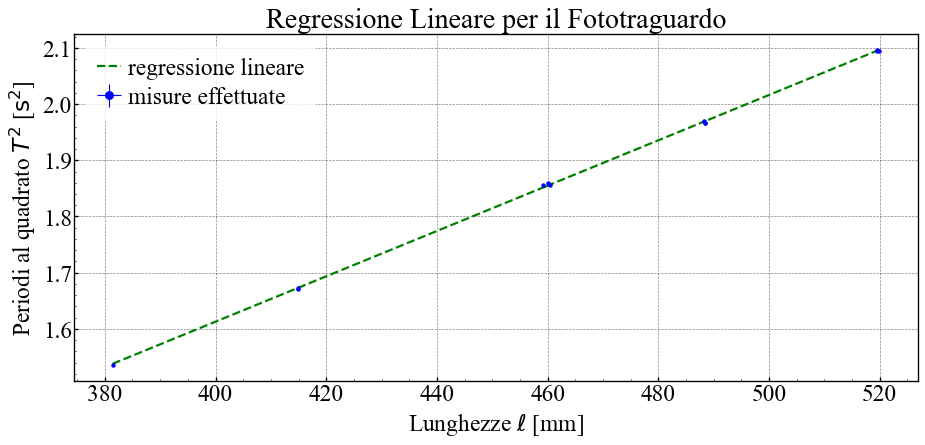

In [38]:
lunghezze = functions.calc_length(lunghezze)

squared_periods = np.square(periods) * (
    1 + (0.01 / (2 * np.pi)) ** 2  # correzione smorzamento (inutile)
)
squared_p_std = 2 * np.multiply(std_periods, periods)
xerr = 0.02
err = np.sqrt(np.square(squared_p_std) + np.square(xerr*0.004))

plt.subplots(figsize=(12, 6))
plt.errorbar(
    lunghezze,
    squared_periods,
    fmt="b. ",
    yerr=squared_p_std,
    xerr=xerr,
    label="misure effettuate",
    markersize=8
)

retta = lambda x, a, b: a * x + b

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze, squared_periods, sigma=err, absolute_sigma=True
)
std = np.sqrt(np.diag(cov))

g_value = -(4 * np.pi**2) / params[0]
g_uncert = -std[0] / params[0] * g_value

plt.plot(
    lunghezze, retta(lunghezze, *params), ls="--", c="g", label="regressione lineare", linewidth=2
)

print(f"~~~~~ Set Fototraguardo (unico per tutti) ~~~~~")
print(f"Lunghezze: {lunghezze}")
print(f"Periodi: {periods}")
print(f"Incertezza sui periodi: {std_periods}")
print(f"Parametri della regressione:\n\tA={params[0]:.6f} ±{uncert[0]:.6f}\n\tB={params[1]:.6f} ±{uncert[1]:.6f}")
print(f"g = {abs(g_value):.1f} ±{g_uncert:.1f} mm/s^2")
print(f"p-value (compatibilità con g attesa): {functions.calc_p_value(abs(g_value), g_uncert, 9806, 12)}")
print(f"p-value (compatibilità con intercetta): {functions.calc_p_value(params[1], (uncert[1]**2 + (params[1]*0.1)**2)**0.5, 0, 12)}")

observed = squared_periods
expected = lunghezze * params[0] + params[1]
chi = functions.calc_chi2(observed, expected, err, 12)
print(f"chi2red: {chi[2]}")

plt.title("Regressione Lineare per il Fototraguardo")
plt.xlabel(r"Lunghezze $\ell$ [mm]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.legend()

plt.savefig("images/Regressione Lineare Fototraguardo.svg")

Calcolo del coefficiente di attrito viscoso $\gamma$

~~~ Set con angolo 3° ~~~
Ampiezza iniziale: 	9.694e-02 ±2.114e+00
Smorzamento gamma: 	5.085e-05 ±1.118e-03
Periodo all'asintoto: 	1.401e+00 ±2.114e+00
~~~ Set con angolo 5° ~~~
Ampiezza iniziale: 	8.406e-04 ±2.044e-04
Smorzamento gamma: 	4.534e-03 ±2.115e-03
Periodo all'asintoto: 	1.498e+00 ±2.279e-04
~~~ Set con angolo 7° ~~~
Ampiezza iniziale: 	2.728e-03 ±4.596e-04
Smorzamento gamma: 	3.280e-03 ±8.798e-04
Periodo all'asintoto: 	1.497e+00 ±4.882e-04
~~~ Set con angolo 10° ~~~
Ampiezza iniziale: 	4.893e-03 ±1.151e-04
Smorzamento gamma: 	4.128e-03 ±1.824e-04
Periodo all'asintoto: 	1.498e+00 ±1.277e-04
~~~ Set con angolo 15° ~~~
Ampiezza iniziale: 	9.851e-03 ±7.646e-05
Smorzamento gamma: 	5.024e-03 ±7.988e-05
Periodo all'asintoto: 	1.499e+00 ±8.689e-05


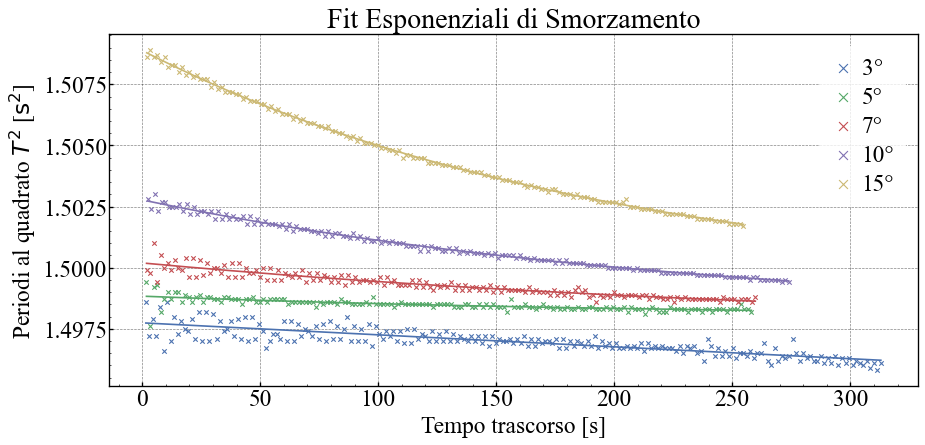

In [39]:
exp_func = lambda x, a, b, c: a * np.exp(-b * x) + c

with open(
    "data/misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi.csv", "r"
) as file:
    data = pd.read_csv(file, delimiter=";", decimal=",").iloc[0:]

angles_used = [3, 5, 7, 10, 15]
asymptote_periods = list()
asymptote_std = list()

plt.subplots(figsize=(12, 6))
for i in range(0, 10, 2):
    X = data.iloc[:, i].dropna().to_numpy()
    Y = data.iloc[:, i + 1].dropna().to_numpy()
    plt.scatter(
        X, Y, marker="x", label=rf"{angles_used[i//2]}°"
    )

    params, cov = scipy.optimize.curve_fit(
        exp_func,
        X,
        Y,
        p0=[0.001, 0.001, 1.5],
        maxfev=3000,
        bounds=((0, 0, 1.4), (10, 1, 1.6)),
    )
    std = np.sqrt(np.diag(cov))

    print(f"~~~ Set con angolo {angles_used[i//2]}° ~~~")
    print(f"Ampiezza iniziale: \t{params[0]:.3e} ±{std[0]:.3e}")
    print(f"Smorzamento gamma: \t{params[1]:.3e} ±{std[1]:.3e}")
    print(f"Periodo all'asintoto: \t{params[2]:.3e} ±{std[2]:.3e}")
    asymptote_periods.append(params[2])
    asymptote_std.append(std[2])
    plt.plot(X, exp_func(X, *params), linewidth=1.5)

plt.title("Fit Esponenziali di Smorzamento")
plt.xlabel(r"Tempo trascorso [s]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.legend()
plt.savefig("images/Fit Esponenziale per Angoli Diversi.svg")

### Regressione lineare per i valori all'asintoto

Abbiamo provato ad aggiungere i valori all'asintoto degli esponenziali per avere una lunghezza in più sulla regressione, tuttavia così facendo peggioriamo di 2 ordini di grandezza l'incertezza su $g$.

~~~ Set Fototraguardo (unico per tutti) con asintotico angoli diversi ~~~
Regression parameters: 0.004034±0.000076 -0.000736±0.000080
g = -9786.4±185.5 mm/s^2


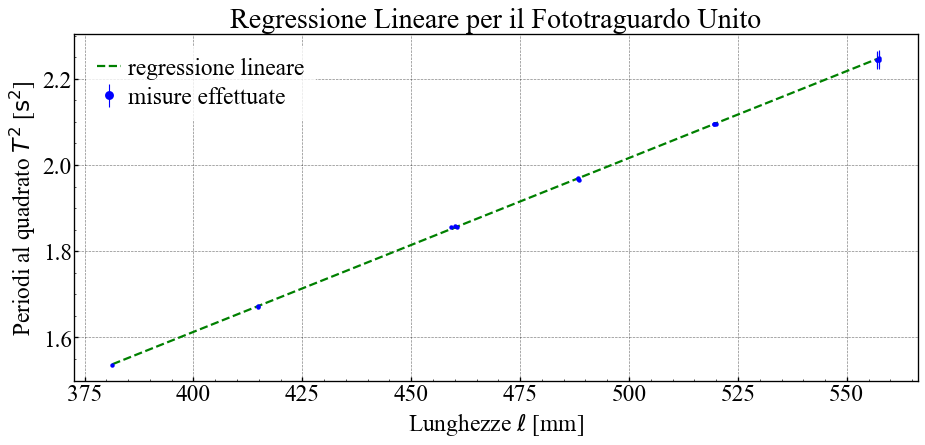

In [40]:
lungz = [30.56, 30.56, 30.00, 30.00] # mm # da excel
lungz = functions.calc_length(lungz)
lunghezze_asint = list(lunghezze) + list(lungz)

periods_asint = list(periods) + asymptote_periods[1:]

errors = list(err) + list(np.sqrt(np.square(asymptote_std[1:]) + np.square(xerr)))

lunghezze_asint, periods_asint, errors = np.array(lunghezze_asint), np.array(periods_asint), np.array(errors)
squared_periods_asympt = np.square(periods_asint)

params, cov = scipy.optimize.curve_fit(
    retta, lunghezze_asint, squared_periods_asympt, sigma=errors, absolute_sigma=True
)

g_value_asynt = -(4 * np.pi**2) / params[0]
g_uncert_asynt = -std[0] / params[0] * g_value_asynt

print

plt.subplots(figsize=(12, 6))
plt.errorbar(
    lunghezze_asint,
    squared_periods_asympt,
    fmt="b. ",
    yerr=errors,
    label="misure effettuate",
    markersize=8
)
#print(lunghezze_asint, squared_periods_asympt,errors, sep="\n")

plt.plot(
    lunghezze_asint, retta(lunghezze_asint, *params), ls="--", c="g", label="regressione lineare", linewidth=2
)

print(f"~~~ Set Fototraguardo (unico per tutti) con asintotico angoli diversi ~~~")
print("Regression parameters:", *[f"{param:.6f}±{errs:.6f}" for param, errs in zip(params, std)])
print(f"g = {g_value_asynt:.1f}±{g_uncert_asynt:.1f} mm/s^2")

plt.title("Regressione Lineare per il Fototraguardo Unito")
plt.xlabel(r"Lunghezze $\ell$ [mm]")
plt.ylabel(r"Periodi al quadrato $T^2$ [$\text{s}^2$]")
plt.legend()

#plt.savefig("images/Regressione Lineare Fototraguardo2.svg")
